In [1]:
#Dependencies and imports

import os
import glob
import random
import pickle
import time
import cupy as cp
from collections import defaultdict
import gc
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

# Set up CuPy for GPU
try:
    import cupy as cp
    GPU_AVAILABLE = True
    print(f" CuPy loaded successfully! Using GPU: {cp.cuda.runtime.getDeviceProperties(0)['name']}")
    xp = cp  # Use cp for GPU operations
except ImportError:
    print(" CuPy not available, falling back to NumPy (CPU)")
    GPU_AVAILABLE = False
    xp = np  # Use np for CPU operations

print(f"Using {'GPU' if GPU_AVAILABLE else 'CPU'} for computation")

 CuPy loaded successfully! Using GPU: b'Tesla T4'
Using GPU for computation


In [5]:
#gathering images
def gather_image_paths(fake_dir, real_dir):
    all_files = []
    # Fake = 1
    if os.path.exists(fake_dir):
        for root, _, files in os.walk(fake_dir):
            for f in files:
                if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                    all_files.append((os.path.join(root, f), 1))
    else:
        print(f"Warning: Fake directory {fake_dir} does not exist!")
    # Real = 0
    if os.path.exists(real_dir):
        for root, _, files in os.walk(real_dir):
            for f in files:
                if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                    all_files.append((os.path.join(root, f), 0))
    else:
        print(f"Warning: Real directory {real_dir} does not exist!")
    return all_files

In [6]:
#preparing batches
def _prepare_numpy_batch(paths_labels, size=(128, 128)):
    imgs = []
    labels = []
    for path, label in paths_labels:
        try:
            img = cv2.imread(path)
            if img is None:
                continue
            if img.shape[0] < 10 or img.shape[1] < 10:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size)
            imgs.append(img.astype(np.float32) / 255.0)
            labels.append(label)
        except Exception:
            continue
    if not imgs:
        return None, None
    X = np.stack(imgs)  # NHWC
    X = np.transpose(X, (0, 3, 1, 2))  # NCHW
    y = np.array(labels, dtype=np.int32)
    return X, y

In [7]:
#Loading shuffled images 
def load_images_shuffled_prefetch(fake_dir, real_dir, batch_size=256, size=(128, 128), max_batches=None):
    all_files = gather_image_paths(fake_dir, real_dir)
    if not all_files:
        raise ValueError(f"No images found in {fake_dir} or {real_dir}")
    # Balance check
    fake_count = sum(1 for _, l in all_files if l == 1)
    real_count = sum(1 for _, l in all_files if l == 0)
    print(f"Found {len(all_files)} images. Fake: {fake_count}, Real: {real_count}")
    # Optional simple balancing if severely imbalanced (undersample majority)
    if abs(fake_count - real_count) > 0.3 * len(all_files):
        print("Significant class imbalance detected; performing simple undersampling.")
        fake_files = [(p, l) for p, l in all_files if l == 1]
        real_files = [(p, l) for p, l in all_files if l == 0]
        m = min(len(fake_files), len(real_files))
        fake_files = random.sample(fake_files, m)
        real_files = random.sample(real_files, m)
        all_files = fake_files + real_files
    random.shuffle(all_files)
    path_batches = [all_files[i:i + batch_size] for i in range(0, len(all_files), batch_size)]
    if max_batches:
        path_batches = path_batches[:max_batches]
    executor = ThreadPoolExecutor(max_workers=2)
    future = None
    for i, paths_labels in enumerate(path_batches):
        if future is None:
            future = executor.submit(_prepare_numpy_batch, paths_labels, size)
            X_np, y_np = future.result()
            future = None
        else:
            next_future = executor.submit(_prepare_numpy_batch, paths_labels, size)
            X_np, y_np = future.result()
            future = next_future
        if X_np is None:
            continue
        X_cp = cp.array(X_np, dtype=cp.float32)
        y_cp = cp.array(y_np, dtype=cp.int32)
        yield X_cp, y_cp
    if future:
        _ = future.result()
    executor.shutdown(wait=True)
        

In [8]:
#convolution
def im2col(X, k, stride=1, pad=0):
    N, C, H, W = X.shape
    H_out = (H + 2 * pad - k) // stride + 1
    W_out = (W + 2 * pad - k) // stride + 1
    X_padded = cp.pad(X, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant')
    shape = (N, C, k, k, H_out, W_out)
    strides = (X_padded.strides[0], X_padded.strides[1], X_padded.strides[2],
               X_padded.strides[3], stride * X_padded.strides[2], stride * X_padded.strides[3])
    patches = cp.lib.stride_tricks.as_strided(X_padded, shape=shape, strides=strides)
    return patches.reshape(N, C * k * k, H_out * W_out)

def col2im(cols, X_shape, k, stride=1, pad=0):
    N, C, H, W = X_shape
    H_out = (H + 2 * pad - k) // stride + 1
    W_out = (W + 2 * pad - k) // stride + 1
    X_padded = cp.zeros((N, C, H + 2 * pad, W + 2 * pad), dtype=cp.float32)
    cols_reshaped = cols.reshape(N, C, k, k, H_out, W_out)
    for i in range(k):
        for j in range(k):
            X_padded[:, :, i:i + stride * H_out:stride, j:j + stride * W_out:stride] += cols_reshaped[:, :, i, j, :, :]
    if pad > 0:
        return X_padded[:, :, pad:-pad, pad:-pad]
    return X_padded

In [9]:
#Conv2D Class
class Conv2D_GPU:
    def __init__(self, in_c, out_c, k, stride=1, pad=0):
        self.in_c = in_c
        self.out_c = out_c
        self.k = k
        self.stride = stride
        self.pad = pad
        scale = np.sqrt(2.0 / (in_c * k * k))
        self.W = cp.array(np.random.randn(out_c, in_c, k, k).astype(np.float32) * scale)
        self.b = cp.zeros(out_c, dtype=cp.float32)
        self.dW = cp.zeros_like(self.W)
        self.db = cp.zeros_like(self.b)

    def forward(self, X):
        self.X_shape = X.shape
        N, C, H, W = X.shape
        self.cols = im2col(X, self.k, self.stride, self.pad)
        W_col = self.W.reshape(self.out_c, -1)
        out = cp.einsum('oi, n i j -> n o j', W_col, self.cols) + self.b[None, :, None]
        H_out = (H + 2 * self.pad - self.k) // self.stride + 1
        W_out = (W + 2 * self.pad - self.k) // self.stride + 1
        return out.reshape(N, self.out_c, H_out, W_out)

    def backward(self, dout, lr=0.001):
        N = self.X_shape[0]
        dout_flat = dout.reshape(N, self.out_c, -1)
        W_col = self.W.reshape(self.out_c, -1)
        dcols = cp.einsum('noj, oi -> nij', dout_flat, W_col)
        self.dW = cp.einsum('noj, nij -> oi', dout_flat, self.cols).reshape(self.W.shape) / N
        self.db = cp.sum(dout_flat, axis=(0, 2)) / N
        # gradient clipping (less strict)
        grad_norm = cp.linalg.norm(self.dW)
        max_norm = 5.0
        if grad_norm > max_norm:
            self.dW *= (max_norm / grad_norm)
            self.db *= (max_norm / grad_norm)
        # update params
        self.W -= lr * self.dW
        self.b -= lr * self.db
        dX = col2im(dcols, self.X_shape, self.k, self.stride, self.pad)
        # free large view
        try:
            del self.cols
        except Exception:
            pass
        return dX

In [10]:
#batch norm class
class BatchNorm_GPU:
    def __init__(self, num_features, eps=1e-5, momentum=0.9):
        self.gamma = cp.ones(num_features, dtype=cp.float32)
        self.beta = cp.zeros(num_features, dtype=cp.float32)
        self.eps = eps
        self.momentum = momentum
        self.running_mean = cp.zeros(num_features, dtype=cp.float32)
        self.running_var = cp.ones(num_features, dtype=cp.float32)
        self.training = True

    def forward(self, X):
        # X: N, C, H, W
        if self.training:
            mean = X.mean(axis=(0, 2, 3), keepdims=True)
            var = X.var(axis=(0, 2, 3), keepdims=True)
            # update running stats (squeeze dims)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean.squeeze()
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var.squeeze()
        else:
            mean = self.running_mean[None, :, None, None]
            var = self.running_var[None, :, None, None]
        self.mean = mean
        self.var = var
        self.std = cp.sqrt(var + self.eps)
        self.X_centered = X - mean
        self.X_norm = self.X_centered / self.std
        out = self.gamma[None, :, None, None] * self.X_norm + self.beta[None, :, None, None]
        return out

    def backward(self, dout, lr=0.001):
        # dout: N, C, H, W
        N, C, H, W = dout.shape
        # gradients for gamma and beta
        dgamma = cp.sum(dout * self.X_norm, axis=(0, 2, 3))
        dbeta = cp.sum(dout, axis=(0, 2, 3))
        # parameter update (simple SGD)
        self.gamma -= lr * (dgamma / N)
        self.beta -= lr * (dbeta / N)
        # gradient wrt input
        dX_norm = dout * self.gamma[None, :, None, None]
        var_eps = self.var + self.eps
        dvar = cp.sum(dX_norm * self.X_centered * -0.5 * (var_eps ** (-1.5)), axis=(0, 2, 3), keepdims=True)
        dmean = cp.sum(dX_norm * -1.0 / cp.sqrt(var_eps), axis=(0, 2, 3), keepdims=True) + \
                dvar * cp.mean(-2.0 * self.X_centered, axis=(0, 2, 3), keepdims=True)
        dX = dX_norm / cp.sqrt(var_eps) + dvar * 2.0 * self.X_centered / (N * H * W) + dmean / (N * H * W)
        return dX


In [11]:
#activation functions
class ReLU_GPU:
    def forward(self, X):
        self.mask = (X > 0)
        return X * self.mask

    def backward(self, dout):
        return dout * self.mask


class Softmax_GPU:
    def forward(self, X):
        max_vals = cp.max(X, axis=1, keepdims=True)
        expX = cp.exp(X - max_vals)
        self.out = expX / cp.sum(expX, axis=1, keepdims=True)
        return self.out

    def backward(self, y_true):
        N = self.out.shape[0]
        if len(y_true.shape) == 1:
            y_onehot = cp.zeros_like(self.out)
            y_onehot[cp.arange(N), y_true] = 1
        else:
            y_onehot = y_true
        return (self.out - y_onehot) / N

In [12]:
#Layers
class Flatten_GPU:
    def forward(self, X):
        self.X_shape = X.shape
        return X.reshape(X.shape[0], -1)

    def backward(self, dout):
        return dout.reshape(self.X_shape)

class Dense_GPU:
    def __init__(self, in_size, out_size):
        scale = np.sqrt(2.0 / in_size)
        self.W = cp.array(np.random.randn(in_size, out_size).astype(np.float32) * scale)
        self.b = cp.zeros(out_size, dtype=cp.float32)

    def forward(self, X):
        self.X = X
        return cp.dot(X, self.W) + self.b

    def backward(self, dout, lr=0.001):
        dW = cp.dot(self.X.T, dout) / self.X.shape[0]
        db = cp.mean(dout, axis=0)
        dX = cp.dot(dout, self.W.T)
        grad_norm = cp.linalg.norm(dW)
        max_norm = 5.0
        if grad_norm > max_norm:
            dW *= (max_norm / grad_norm)
            db *= (max_norm / grad_norm)
        self.W -= lr * dW
        self.b -= lr * db
        return dX

In [13]:
#Max pooling
class MaxPool2D_GPU:
    def __init__(self, pool_size=2, stride=2):
        self.pool = pool_size
        self.stride = stride

    def forward(self, X):
        N, C, H, W = X.shape
        ph = self.pool
        pw = self.pool
        assert H % ph == 0 and W % pw == 0, "H/W must be divisible by pool size"
        H_out = H // ph
        W_out = W // pw
        Xr = X.reshape(N, C, H_out, ph, W_out, pw)
        out = Xr.max(axis=(3, 5))
        self.X_shape = X.shape
        self.Xr = Xr
        self.out = out
        return out

    def backward(self, dout):
        Xr = self.Xr
        out_expanded = dout[:, :, :, None, :, None]
        max_vals = self.out[:, :, :, None, :, None]
        mask = (Xr == max_vals)
        counts = mask.sum(axis=(3, 5), keepdims=True)
        counts = cp.where(counts == 0, 1, counts)
        grad_per_pos = out_expanded / counts
        dXr = mask * grad_per_pos
        dX = dXr.reshape(self.X_shape)
        try:
            del self.Xr, self.out
        except Exception:
            pass
        return dX

In [14]:
#CNN
class FastCNN_GPU:
    def __init__(self, input_shape=(128, 128, 3), num_classes=2):
        self.conv1 = Conv2D_GPU(3, 16, 3, 1, 1)
        self.bn1 = BatchNorm_GPU(16)
        self.relu1 = ReLU_GPU()
        self.pool1 = MaxPool2D_GPU(2, 2)

        self.conv2 = Conv2D_GPU(16, 32, 3, 1, 1)
        self.bn2 = BatchNorm_GPU(32)
        self.relu2 = ReLU_GPU()
        self.pool2 = MaxPool2D_GPU(2, 2)

        self.conv3 = Conv2D_GPU(32, 64, 3, 1, 1)
        self.bn3 = BatchNorm_GPU(64)
        self.relu3 = ReLU_GPU()
        self.pool3 = MaxPool2D_GPU(2, 2)

        self.flatten = Flatten_GPU()
        self.fc = Dense_GPU(64 * 16 * 16, num_classes)
        self.softmax = Softmax_GPU()

    def forward(self, X):
        x = self.conv1.forward(X)
        x = self.bn1.forward(x)
        x = self.relu1.forward(x)
        x = self.pool1.forward(x)

        x = self.conv2.forward(x)
        x = self.bn2.forward(x)
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)

        x = self.conv3.forward(x)
        x = self.bn3.forward(x)
        x = self.relu3.forward(x)
        x = self.pool3.forward(x)

        self.X_flat = self.flatten.forward(x)
        logits = self.fc.forward(self.X_flat)
        probs = self.softmax.forward(logits)
        return probs

    def backward(self, y_true, lr=0.003):
        dout = self.softmax.backward(y_true)
        dout = self.fc.backward(dout, lr)
        dout = self.flatten.backward(dout)

        dout = self.pool3.backward(dout)
        dout = self.relu3.backward(dout)
        dout = self.bn3.backward(dout, lr)
        dout = self.conv3.backward(dout, lr)

        dout = self.pool2.backward(dout)
        dout = self.relu2.backward(dout)
        dout = self.bn2.backward(dout, lr)
        dout = self.conv2.backward(dout, lr)

        dout = self.pool1.backward(dout)
        dout = self.relu1.backward(dout)
        dout = self.bn1.backward(dout, lr)
        dout = self.conv1.backward(dout, lr)
        return dout

In [15]:
#Loss and accuracy
def cross_entropy_loss(y_pred, y_true):
    eps = 1e-12
    y_pred = cp.clip(y_pred, eps, 1 - eps)
    N = y_pred.shape[0]
    if len(y_true.shape) == 1:
        y_onehot = cp.zeros_like(y_pred)
        y_onehot[cp.arange(N), y_true] = 1
    else:
        y_onehot = y_true
    return -cp.mean(cp.sum(y_onehot * cp.log(y_pred), axis=1))

def accuracy(y_pred, y_true):
    preds = cp.argmax(y_pred, axis=1)
    if len(y_true.shape) > 1:
        y_true_labels = cp.argmax(y_true, axis=1)
    else:
        y_true_labels = y_true
    return cp.mean(preds == y_true_labels)

In [17]:
#Saving and loading the model
def save_model_state(model, path):
    state = {
        'conv1_W': cp.asnumpy(model.conv1.W),
        'conv1_b': cp.asnumpy(model.conv1.b),
        'bn1_gamma': cp.asnumpy(model.bn1.gamma),
        'bn1_beta': cp.asnumpy(model.bn1.beta),
        'bn1_rm': cp.asnumpy(model.bn1.running_mean),
        'bn1_rv': cp.asnumpy(model.bn1.running_var),

        'conv2_W': cp.asnumpy(model.conv2.W),
        'conv2_b': cp.asnumpy(model.conv2.b),
        'bn2_gamma': cp.asnumpy(model.bn2.gamma),
        'bn2_beta': cp.asnumpy(model.bn2.beta),
        'bn2_rm': cp.asnumpy(model.bn2.running_mean),
        'bn2_rv': cp.asnumpy(model.bn2.running_var),

        'conv3_W': cp.asnumpy(model.conv3.W),
        'conv3_b': cp.asnumpy(model.conv3.b),
        'bn3_gamma': cp.asnumpy(model.bn3.gamma),
        'bn3_beta': cp.asnumpy(model.bn3.beta),
        'bn3_rm': cp.asnumpy(model.bn3.running_mean),
        'bn3_rv': cp.asnumpy(model.bn3.running_var),

        'fc_W': cp.asnumpy(model.fc.W),
        'fc_b': cp.asnumpy(model.fc.b),
    }
    with open(path, 'wb') as f:
        pickle.dump(state, f)


def load_model_state(model, path):
    with open(path, 'rb') as f:
        state = pickle.load(f)
    model.conv1.W = cp.array(state['conv1_W'])
    model.conv1.b = cp.array(state['conv1_b'])
    model.bn1.gamma = cp.array(state['bn1_gamma'])
    model.bn1.beta = cp.array(state['bn1_beta'])
    model.bn1.running_mean = cp.array(state['bn1_rm'])
    model.bn1.running_var = cp.array(state['bn1_rv'])

    model.conv2.W = cp.array(state['conv2_W'])
    model.conv2.b = cp.array(state['conv2_b'])
    model.bn2.gamma = cp.array(state['bn2_gamma'])
    model.bn2.beta = cp.array(state['bn2_beta'])
    model.bn2.running_mean = cp.array(state['bn2_rm'])
    model.bn2.running_var = cp.array(state['bn2_rv'])

    model.conv3.W = cp.array(state['conv3_W'])
    model.conv3.b = cp.array(state['conv3_b'])
    model.bn3.gamma = cp.array(state['bn3_gamma'])
    model.bn3.beta = cp.array(state['bn3_beta'])
    model.bn3.running_mean = cp.array(state['bn3_rm'])
    model.bn3.running_var = cp.array(state['bn3_rv'])

    model.fc.W = cp.array(state['fc_W'])
    model.fc.b = cp.array(state['fc_b'])

In [18]:
# -----------------------------
# Training Loop
# -----------------------------
def train_optimized(fake_dir, real_dir, epochs=20, batch_size=128, lr=0.003, batches_per_epoch=250):
    model = FastCNN_GPU()
    start_time = time.time()
    best_acc = 0.0
    os.makedirs("models", exist_ok=True)
    print(f"Starting training: epochs={epochs}, batch_size={batch_size}, batches_per_epoch={batches_per_epoch}, lr={lr}")
    for epoch in range(epochs):
        epoch_start = time.time()
        total_loss = 0.0
        total_acc = 0.0
        batches = 0
        # lr schedule
        current_lr = lr * (0.95 ** epoch)
        # set batchnorm training mode
        model.bn1.training = model.bn2.training = model.bn3.training = True
        gen = load_images_shuffled_prefetch(fake_dir, real_dir, batch_size=batch_size, max_batches=batches_per_epoch)
        with tqdm(total=batches_per_epoch, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for X, y in gen:
                # y already cupy-arr in generator
                # Forward
                probs = model.forward(X)
                loss = cross_entropy_loss(probs, y)
                acc = accuracy(probs, y)
                # Backward and update
                model.backward(y, current_lr)
                total_loss += float(loss)
                total_acc += float(acc)
                batches += 1
                pbar.set_postfix({'Loss': f'{total_loss/batches:.4f}', 'Acc': f'{total_acc/batches:.4f}', 'LR': f'{current_lr:.6f}'})
                pbar.update(1)
                # occasional cleanup
                if batches % 200 == 0:
                    try:
                        gc.collect()
                        cp.get_default_memory_pool().free_all_blocks()
                    except Exception:
                        pass
        if batches == 0:
            print("No batches processed; check dataset paths.")
            break
        avg_loss = total_loss / batches
        avg_acc = total_acc / batches
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} complete. Loss={avg_loss:.4f} Acc={avg_acc:.4f} LR={current_lr:.6f} Time={epoch_time/60:.2f}m")
        # Save best
        if avg_acc > best_acc:
            best_acc = avg_acc
            save_model_state(model, os.path.join("models", "best_model.pkl"))
            print(f" New best model saved: {best_acc:.4f}")
        # periodic checkpoint
        if (epoch + 1) % 5 == 0:
            save_model_state(model, os.path.join("models", f"ckpt_epoch_{epoch+1}.pkl"))
    total_time = time.time() - start_time
    print(f"Training finished. Total time: {total_time/60:.2f}m. Best acc: {best_acc:.4f}")
    return model

# -----------------------------
# Validation
# -----------------------------
def validate_model(fake_dir, real_dir, model_path, batch_size=128, max_batches=100):
    model = FastCNN_GPU()
    load_model_state(model, model_path)
    # set batchnorm to eval
    model.bn1.training = model.bn2.training = model.bn3.training = False
    val_gen = load_images_shuffled_prefetch(fake_dir, real_dir, batch_size=batch_size, max_batches=max_batches)
    total_acc = 0.0
    batches = 0
    for X, y in val_gen:
        probs = model.forward(X)
        acc = accuracy(probs, y)
        total_acc += float(acc)
        batches += 1
    final_acc = total_acc / batches if batches > 0 else 0.0
    print(f"Validation Accuracy: {final_acc:.4f} over {batches} batches")
    return final_acc

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    # Update these to your dataset
    fake_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train/Fake"
    real_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train/Real"
    try:
        model = train_optimized(
            fake_dir=fake_dir,
            real_dir=real_dir,
            epochs=30,
            batch_size=128,
            lr=0.003,
            batches_per_epoch=300
        )
        print("Training finished. Validating best model...")
        validate_model(fake_dir, real_dir, os.path.join("models", "best_model.pkl"), batch_size=128, max_batches=100)
    except Exception as e:
        print("Training failed with exception:", e)
        import traceback
        traceback.print_exc()

Starting training: epochs=30, batch_size=128, batches_per_epoch=300, lr=0.003


Epoch 1/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 1/30: 100%|██████████| 300/300 [15:02<00:00,  3.01s/it, Loss=0.8469, Acc=0.5273, LR=0.003000]  


Epoch 1 complete. Loss=0.8469 Acc=0.5273 LR=0.003000 Time=15.04m
 New best model saved: 0.5273


Epoch 2/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 2/30: 100%|██████████| 300/300 [09:25<00:00,  1.89s/it, Loss=0.7702, Acc=0.5645, LR=0.002850]  


Epoch 2 complete. Loss=0.7702 Acc=0.5645 LR=0.002850 Time=9.43m
 New best model saved: 0.5645


Epoch 3/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 3/30: 100%|██████████| 300/300 [08:49<00:00,  1.77s/it, Loss=0.7291, Acc=0.5924, LR=0.002707]  


Epoch 3 complete. Loss=0.7291 Acc=0.5924 LR=0.002707 Time=8.83m
 New best model saved: 0.5924


Epoch 4/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 4/30: 100%|██████████| 300/300 [07:41<00:00,  1.54s/it, Loss=0.6993, Acc=0.6131, LR=0.002572] 


Epoch 4 complete. Loss=0.6993 Acc=0.6131 LR=0.002572 Time=7.69m
 New best model saved: 0.6131


Epoch 5/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 5/30: 100%|██████████| 300/300 [07:15<00:00,  1.45s/it, Loss=0.6856, Acc=0.6284, LR=0.002444] 


Epoch 5 complete. Loss=0.6856 Acc=0.6284 LR=0.002444 Time=7.26m
 New best model saved: 0.6284


Epoch 6/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 6/30: 100%|██████████| 300/300 [07:07<00:00,  1.42s/it, Loss=0.6703, Acc=0.6392, LR=0.002321]  


Epoch 6 complete. Loss=0.6703 Acc=0.6392 LR=0.002321 Time=7.12m
 New best model saved: 0.6392


Epoch 7/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 7/30: 100%|██████████| 300/300 [06:38<00:00,  1.33s/it, Loss=0.6575, Acc=0.6460, LR=0.002205]


Epoch 7 complete. Loss=0.6575 Acc=0.6460 LR=0.002205 Time=6.64m
 New best model saved: 0.6460


Epoch 8/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 8/30: 100%|██████████| 300/300 [06:36<00:00,  1.32s/it, Loss=0.6514, Acc=0.6516, LR=0.002095]  


Epoch 8 complete. Loss=0.6514 Acc=0.6516 LR=0.002095 Time=6.61m
 New best model saved: 0.6516


Epoch 9/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 9/30: 100%|██████████| 300/300 [06:16<00:00,  1.25s/it, Loss=0.6435, Acc=0.6579, LR=0.001990] 


Epoch 9 complete. Loss=0.6435 Acc=0.6579 LR=0.001990 Time=6.27m
 New best model saved: 0.6579


Epoch 10/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 10/30: 100%|██████████| 300/300 [06:19<00:00,  1.26s/it, Loss=0.6402, Acc=0.6612, LR=0.001891] 


Epoch 10 complete. Loss=0.6402 Acc=0.6612 LR=0.001891 Time=6.32m
 New best model saved: 0.6612


Epoch 11/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 11/30: 100%|██████████| 300/300 [06:03<00:00,  1.21s/it, Loss=0.6347, Acc=0.6604, LR=0.001796] 


Epoch 11 complete. Loss=0.6347 Acc=0.6604 LR=0.001796 Time=6.06m


Epoch 12/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 12/30: 100%|██████████| 300/300 [06:04<00:00,  1.22s/it, Loss=0.6323, Acc=0.6660, LR=0.001706] 


Epoch 12 complete. Loss=0.6323 Acc=0.6660 LR=0.001706 Time=6.08m
 New best model saved: 0.6660


Epoch 13/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 13/30: 100%|██████████| 300/300 [05:59<00:00,  1.20s/it, Loss=0.6298, Acc=0.6661, LR=0.001621] 


Epoch 13 complete. Loss=0.6298 Acc=0.6661 LR=0.001621 Time=5.99m
 New best model saved: 0.6661


Epoch 14/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 14/30: 100%|██████████| 300/300 [05:50<00:00,  1.17s/it, Loss=0.6242, Acc=0.6715, LR=0.001540]


Epoch 14 complete. Loss=0.6242 Acc=0.6715 LR=0.001540 Time=5.85m
 New best model saved: 0.6715


Epoch 15/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 15/30: 100%|██████████| 300/300 [06:41<00:00,  1.34s/it, Loss=0.6158, Acc=0.6766, LR=0.001463]  


Epoch 15 complete. Loss=0.6158 Acc=0.6766 LR=0.001463 Time=6.70m
 New best model saved: 0.6766


Epoch 16/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 16/30: 100%|██████████| 300/300 [06:32<00:00,  1.31s/it, Loss=0.6148, Acc=0.6790, LR=0.001390]  


Epoch 16 complete. Loss=0.6148 Acc=0.6790 LR=0.001390 Time=6.54m
 New best model saved: 0.6790


Epoch 17/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 17/30: 100%|██████████| 300/300 [06:03<00:00,  1.21s/it, Loss=0.6106, Acc=0.6808, LR=0.001320] 


Epoch 17 complete. Loss=0.6106 Acc=0.6808 LR=0.001320 Time=6.05m
 New best model saved: 0.6808


Epoch 18/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 18/30: 100%|██████████| 300/300 [05:47<00:00,  1.16s/it, Loss=0.6117, Acc=0.6830, LR=0.001254] 


Epoch 18 complete. Loss=0.6117 Acc=0.6830 LR=0.001254 Time=5.78m
 New best model saved: 0.6830


Epoch 19/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 19/30: 100%|██████████| 300/300 [05:30<00:00,  1.10s/it, Loss=0.6080, Acc=0.6811, LR=0.001192]


Epoch 19 complete. Loss=0.6080 Acc=0.6811 LR=0.001192 Time=5.51m


Epoch 20/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 20/30: 100%|██████████| 300/300 [06:02<00:00,  1.21s/it, Loss=0.6029, Acc=0.6862, LR=0.001132] 


Epoch 20 complete. Loss=0.6029 Acc=0.6862 LR=0.001132 Time=6.03m
 New best model saved: 0.6862


Epoch 21/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 21/30: 100%|██████████| 300/300 [06:10<00:00,  1.24s/it, Loss=0.6059, Acc=0.6855, LR=0.001075] 


Epoch 21 complete. Loss=0.6059 Acc=0.6855 LR=0.001075 Time=6.18m


Epoch 22/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 22/30: 100%|██████████| 300/300 [06:01<00:00,  1.20s/it, Loss=0.6046, Acc=0.6849, LR=0.001022] 


Epoch 22 complete. Loss=0.6046 Acc=0.6849 LR=0.001022 Time=6.02m


Epoch 23/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 23/30: 100%|██████████| 300/300 [05:59<00:00,  1.20s/it, Loss=0.6000, Acc=0.6898, LR=0.000971] 


Epoch 23 complete. Loss=0.6000 Acc=0.6898 LR=0.000971 Time=6.00m
 New best model saved: 0.6898


Epoch 24/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 24/30: 100%|██████████| 300/300 [05:53<00:00,  1.18s/it, Loss=0.5998, Acc=0.6869, LR=0.000922] 


Epoch 24 complete. Loss=0.5998 Acc=0.6869 LR=0.000922 Time=5.89m


Epoch 25/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 25/30: 100%|██████████| 300/300 [06:02<00:00,  1.21s/it, Loss=0.5988, Acc=0.6916, LR=0.000876] 


Epoch 25 complete. Loss=0.5988 Acc=0.6916 LR=0.000876 Time=6.04m
 New best model saved: 0.6916


Epoch 26/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 26/30: 100%|██████████| 300/300 [05:58<00:00,  1.20s/it, Loss=0.5952, Acc=0.6901, LR=0.000832] 


Epoch 26 complete. Loss=0.5952 Acc=0.6901 LR=0.000832 Time=5.98m


Epoch 27/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 27/30: 100%|██████████| 300/300 [06:01<00:00,  1.20s/it, Loss=0.5929, Acc=0.6950, LR=0.000791] 


Epoch 27 complete. Loss=0.5929 Acc=0.6950 LR=0.000791 Time=6.02m
 New best model saved: 0.6950


Epoch 28/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 28/30: 100%|██████████| 300/300 [06:41<00:00,  1.34s/it, Loss=0.5947, Acc=0.6941, LR=0.000751]  


Epoch 28 complete. Loss=0.5947 Acc=0.6941 LR=0.000751 Time=6.70m


Epoch 29/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 29/30: 100%|██████████| 300/300 [06:40<00:00,  1.34s/it, Loss=0.5950, Acc=0.6932, LR=0.000713]  


Epoch 29 complete. Loss=0.5950 Acc=0.6932 LR=0.000713 Time=6.68m


Epoch 30/30:   0%|          | 0/300 [00:00<?, ?it/s]

Found 140002 images. Fake: 70001, Real: 70001


Epoch 30/30: 100%|██████████| 300/300 [06:24<00:00,  1.28s/it, Loss=0.5936, Acc=0.6923, LR=0.000678] 


Epoch 30 complete. Loss=0.5936 Acc=0.6923 LR=0.000678 Time=6.42m
Training finished. Total time: 203.73m. Best acc: 0.6950
Training finished. Validating best model...
Found 140002 images. Fake: 70001, Real: 70001
Validation Accuracy: 0.6941 over 100 batches


🚀 QUICK MODEL TEST
Testing saved model on 200 images...
Model path: /kaggle/working/models/best_model.pkl
✓ Model loaded successfully
✓ Model set to evaluation mode
✓ Found 200 test images (100 real, 100 fake)


Testing: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


✓ Successfully processed 200 images

📊 TEST RESULTS (n=200)
Overall Accuracy: 0.5950
Real Images Accuracy: 0.6000
Fake Images Accuracy: 0.5900
Average Confidence: 0.7022


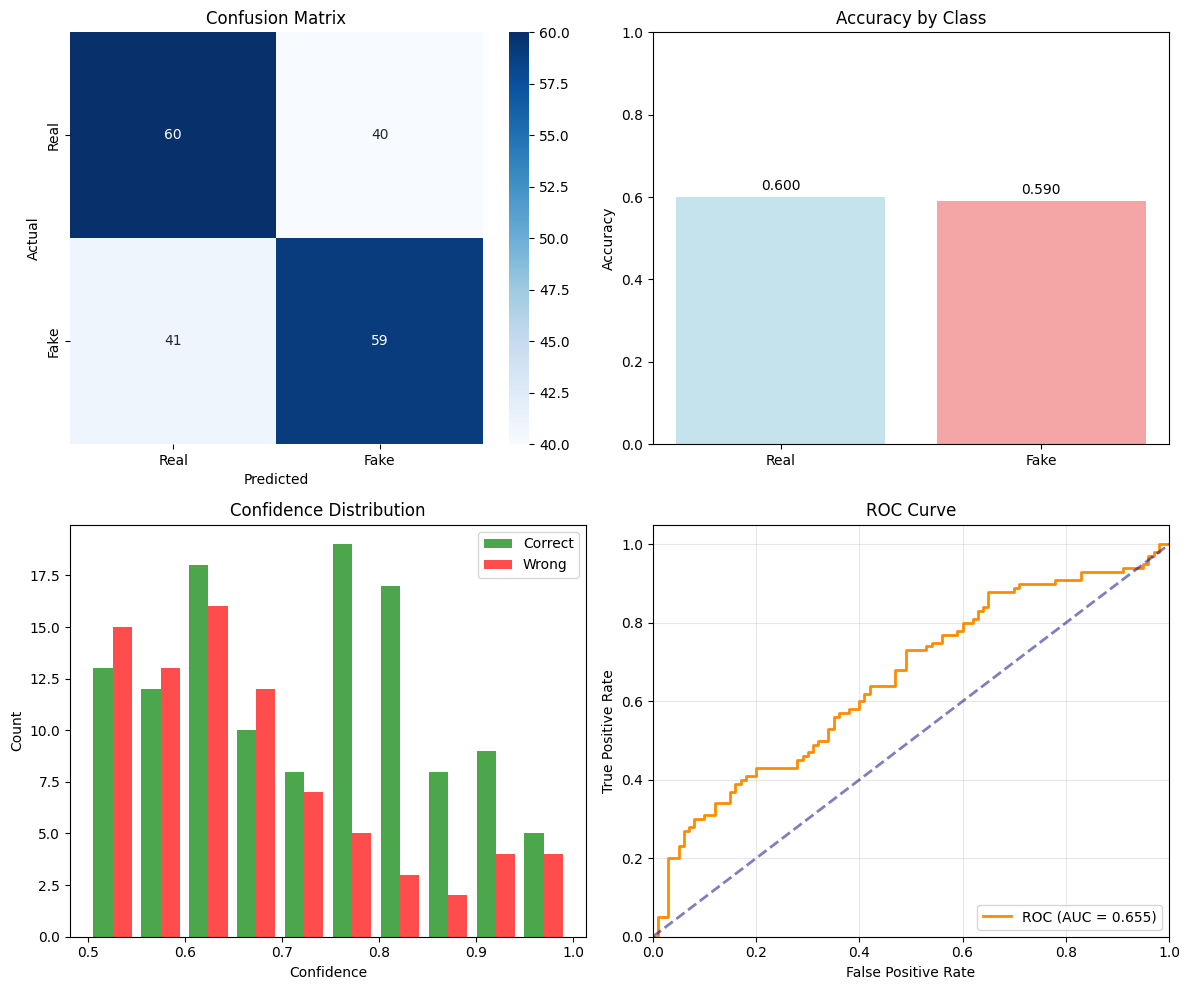


📈 Detailed Classification Report:
              precision    recall  f1-score   support

        Real     0.5941    0.6000    0.5970       100
        Fake     0.5960    0.5900    0.5930       100

    accuracy                         0.5950       200
   macro avg     0.5950    0.5950    0.5950       200
weighted avg     0.5950    0.5950    0.5950       200



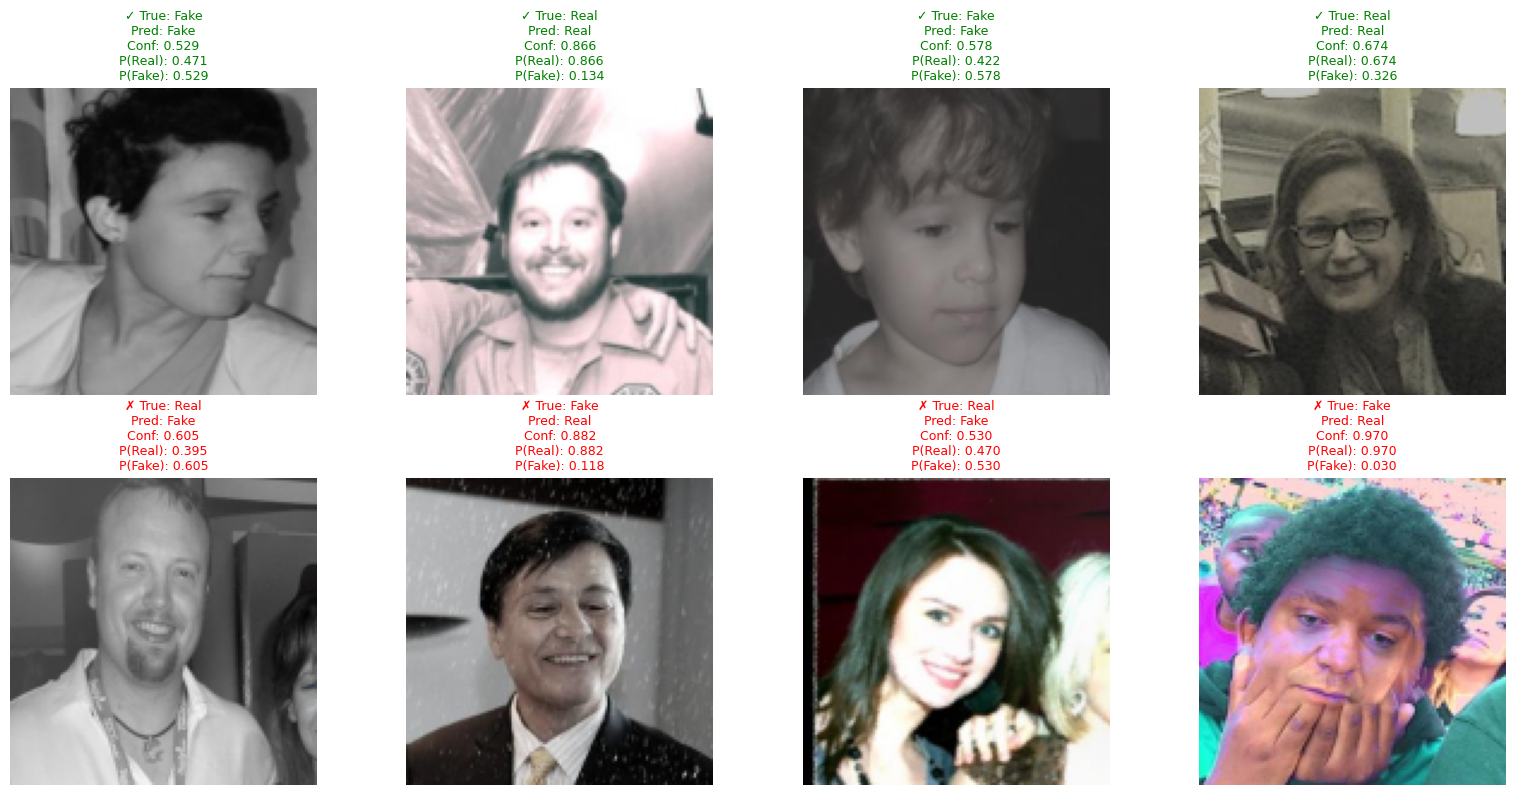


 QUICK TEST COMPLETE

 FINAL METRICS:
   Overall Accuracy: 0.5950
   Real Images Accuracy: 0.6000
   Fake Images Accuracy: 0.5900
   ROC AUC: 0.6555
   Average Confidence: 0.7022


In [19]:
# testing_saved_model.py
import os
import cv2
import time
import cupy as cp
import numpy as np
from tqdm import tqdm
import pickle
import random
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Import your existing classes (make sure they're available)
#from optimized_training_fixed_bn import FastCNN_GPU, load_model_state, load_images_shuffled_prefetch, cross_entropy_loss, accuracy

# -----------------------------
# Test Saved Model on Small Subset
# -----------------------------
def test_saved_model_small_subset(model_path, fake_dir, real_dir, num_samples=200, batch_size=32):
    """Test the saved model on a small subset of images"""
    print(f"Testing saved model on {num_samples} images...")
    print(f"Model path: {model_path}")
    
    # Load the model
    model = FastCNN_GPU()
    try:
        load_model_state(model, model_path)
        print("✓ Model loaded successfully")
    except Exception as e:
        print(f"✗ Error loading model: {e}")
        return None
    
    # Set to evaluation mode
    model.bn1.training = model.bn2.training = model.bn3.training = False
    print("✓ Model set to evaluation mode")
    
    # Get a small subset of files
    all_files = []
    
    # Get fake images
    fake_count = 0
    if os.path.exists(fake_dir):
        for root, _, files in os.walk(fake_dir):
            for f in files:
                if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                    all_files.append((os.path.join(root, f), 1))
                    fake_count += 1
                    if fake_count >= num_samples // 2:
                        break
            if fake_count >= num_samples // 2:
                break
    else:
        print(f"✗ Fake directory not found: {fake_dir}")
        return None
    
    # Get real images
    real_count = 0
    if os.path.exists(real_dir):
        for root, _, files in os.walk(real_dir):
            for f in files:
                if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                    all_files.append((os.path.join(root, f), 0))
                    real_count += 1
                    if real_count >= num_samples // 2:
                        break
            if real_count >= num_samples // 2:
                break
    else:
        print(f"✗ Real directory not found: {real_dir}")
        return None
    
    print(f"✓ Found {len(all_files)} test images ({real_count} real, {fake_count} fake)")
    
    # Shuffle and process
    random.shuffle(all_files)
    
    # Process in batches
    all_predictions = []
    all_true_labels = []
    all_probabilities = []
    all_confidences = []
    processed_files = []
    
    total_batches = (len(all_files) + batch_size - 1) // batch_size
    
    with tqdm(total=total_batches, desc="Testing") as pbar:
        for i in range(0, len(all_files), batch_size):
            batch_files = all_files[i:i + batch_size]
            paths, true_labels = zip(*batch_files)
            
            # Load and process batch
            X_batch = []
            valid_paths = []
            valid_labels = []
            
            for path, label in zip(paths, true_labels):
                try:
                    img = cv2.imread(path)
                    if img is None:
                        continue
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (128, 128))
                    img_tensor = img.astype(np.float32) / 255.0
                    img_tensor = np.transpose(img_tensor, (2, 0, 1))  # HWC to CHW
                    X_batch.append(img_tensor)
                    valid_paths.append(path)
                    valid_labels.append(label)
                except Exception as e:
                    continue
            
            if not X_batch:
                pbar.update(1)
                continue
            
            X_batch = np.array(X_batch)
            X_cp = cp.array(X_batch, dtype=cp.float32)
            y_true = cp.array(valid_labels, dtype=cp.int32)
            
            # Forward pass
            try:
                probs = model.forward(X_cp)
                batch_predictions = cp.argmax(probs, axis=1).get()
                batch_probabilities = cp.asnumpy(probs)
                batch_confidences = np.max(batch_probabilities, axis=1)
                
                # Store results
                all_predictions.extend(batch_predictions.tolist())
                all_true_labels.extend(valid_labels)
                all_probabilities.extend(batch_probabilities.tolist())
                all_confidences.extend(batch_confidences.tolist())
                processed_files.extend(valid_paths)
                
            except Exception as e:
                print(f"Error in forward pass: {e}")
            
            pbar.update(1)
    
    print(f"✓ Successfully processed {len(all_true_labels)} images")
    
    return {
        'true_labels': all_true_labels,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'confidences': all_confidences,
        'files': processed_files
    }

# -----------------------------
# Visualization for Small Test
# -----------------------------
def plot_mini_results(test_results):
    """Create compact visualizations for the small test"""
    
    true_labels = test_results['true_labels']
    predictions = test_results['predictions']
    probabilities = test_results['probabilities']
    confidences = test_results['confidences']
    
    # Calculate basic metrics
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    real_indices = [i for i, label in enumerate(true_labels) if label == 0]
    fake_indices = [i for i, label in enumerate(true_labels) if label == 1]
    
    real_accuracy = np.mean(np.array(predictions)[real_indices] == 0) if real_indices else 0
    fake_accuracy = np.mean(np.array(predictions)[fake_indices] == 1) if fake_indices else 0
    
    print(f"\n📊 TEST RESULTS (n={len(true_labels)})")
    print("=" * 50)
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Real Images Accuracy: {real_accuracy:.4f}")
    print(f"Fake Images Accuracy: {fake_accuracy:.4f}")
    print(f"Average Confidence: {np.mean(confidences):.4f}")
    
    # Create a compact visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. Accuracy by Class
    classes = ['Real', 'Fake']
    accuracies = [real_accuracy, fake_accuracy]
    colors = ['lightblue', 'lightcoral']
    ax2.bar(classes, accuracies, color=colors, alpha=0.7)
    ax2.set_title('Accuracy by Class')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1)
    for i, v in enumerate(accuracies):
        ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # 3. Confidence Distribution
    correct_conf = [conf for i, conf in enumerate(confidences) if predictions[i] == true_labels[i]]
    wrong_conf = [conf for i, conf in enumerate(confidences) if predictions[i] != true_labels[i]]
    
    ax3.hist([correct_conf, wrong_conf], bins=10, alpha=0.7, 
             label=['Correct', 'Wrong'], color=['green', 'red'])
    ax3.set_title('Confidence Distribution')
    ax3.set_xlabel('Confidence')
    ax3.set_ylabel('Count')
    ax3.legend()
    
    # 4. ROC Curve
    y_scores = np.array(probabilities)[:, 1]  # Probability of being fake
    fpr, tpr, _ = roc_curve(true_labels, y_scores)
    roc_auc = auc(fpr, tpr)
    
    ax4.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
    ax4.set_xlim([0.0, 1.0])
    ax4.set_ylim([0.0, 1.05])
    ax4.set_xlabel('False Positive Rate')
    ax4.set_ylabel('True Positive Rate')
    ax4.set_title('ROC Curve')
    ax4.legend(loc="lower right")
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('mini_test_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print detailed classification report
    print("\n📈 Detailed Classification Report:")
    print("=" * 50)
    print(classification_report(true_labels, predictions, 
                              target_names=['Real', 'Fake'], 
                              digits=4))
    
    return {
        'overall_accuracy': accuracy,
        'real_accuracy': real_accuracy,
        'fake_accuracy': fake_accuracy,
        'roc_auc': roc_auc,
        'avg_confidence': np.mean(confidences)
    }

# -----------------------------
# Sample Predictions Display
# -----------------------------
def show_sample_predictions(test_results, num_samples=8):
    """Show a few sample predictions with images"""
    
    true_labels = test_results['true_labels']
    predictions = test_results['predictions']
    probabilities = test_results['probabilities']
    files = test_results['files']
    confidences = test_results['confidences']
    
    # Find some correct and incorrect examples
    correct_indices = []
    incorrect_indices = []
    
    for i, (true, pred) in enumerate(zip(true_labels, predictions)):
        if true == pred and len(correct_indices) < num_samples // 2:
            correct_indices.append(i)
        elif true != pred and len(incorrect_indices) < num_samples // 2:
            incorrect_indices.append(i)
    
    sample_indices = correct_indices + incorrect_indices
    
    # Create display
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for idx, ax_idx in enumerate(sample_indices):
        if idx >= len(axes):
            break
            
        path = files[ax_idx]
        true_label = true_labels[ax_idx]
        pred_label = predictions[ax_idx]
        confidence = confidences[ax_idx]
        prob_real = probabilities[ax_idx][0]
        prob_fake = probabilities[ax_idx][1]
        
        # Load and display image
        try:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (128, 128))
            
            ax = axes[idx]
            ax.imshow(img)
            ax.axis('off')
            
            # Color code: green for correct, red for incorrect
            color = 'green' if true_label == pred_label else 'red'
            status = "✓" if true_label == pred_label else "✗"
            
            ax.set_title(f'{status} True: {"Real" if true_label == 0 else "Fake"}\n'
                        f'Pred: {"Real" if pred_label == 0 else "Fake"}\n'
                        f'Conf: {confidence:.3f}\n'
                        f'P(Real): {prob_real:.3f}\n'
                        f'P(Fake): {prob_fake:.3f}', 
                        color=color, fontsize=9)
                        
        except Exception as e:
            print(f"Error displaying image {path}: {e}")
            axes[idx].axis('off')
            axes[idx].set_title(f"Error loading image", color='red')
    
    # Hide unused subplots
    for idx in range(len(sample_indices), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions_mini.png', dpi=150, bbox_inches='tight')
    plt.show()

# -----------------------------
# Main Testing Function
# -----------------------------
def run_quick_test(model_path, fake_dir, real_dir, num_test_images=200):
    """Run a quick comprehensive test on the saved model"""
    print("🚀 QUICK MODEL TEST")
    print("=" * 60)
    
    # Test the model
    test_results = test_saved_model_small_subset(
        model_path=model_path,
        fake_dir=fake_dir,
        real_dir=real_dir,
        num_samples=num_test_images,
        batch_size=32
    )
    
    if test_results is None:
        print(" Testing failed!")
        return
    
    # Plot results
    metrics = plot_mini_results(test_results)
    
    # Show sample predictions
    show_sample_predictions(test_results)
    
    print("\n" + "=" * 60)
    print(" QUICK TEST COMPLETE")
    print("=" * 60)
    
    return metrics

# -----------------------------
# Usage Example
# -----------------------------
if __name__ == "__main__":
    # Update these paths to match your environment
    MODEL_PATH = "/kaggle/working/models/best_model.pkl"  # Path to your saved model
    FAKE_DIR = "/kaggle/input/deepfake-and-real-images/Dataset/Test/Fake"
    REAL_DIR = "/kaggle/input/deepfake-and-real-images/Dataset/Test/Real"
    
    try:
        metrics = run_quick_test(
            model_path=MODEL_PATH,
            fake_dir=FAKE_DIR,
            real_dir=REAL_DIR,
            num_test_images=200  # Test on 200 images (100 real, 100 fake)
        )
        
        if metrics:
            print(f"\n FINAL METRICS:")
            print(f"   Overall Accuracy: {metrics['overall_accuracy']:.4f}")
            print(f"   Real Images Accuracy: {metrics['real_accuracy']:.4f}")
            print(f"   Fake Images Accuracy: {metrics['fake_accuracy']:.4f}")
            print(f"   ROC AUC: {metrics['roc_auc']:.4f}")
            print(f"   Average Confidence: {metrics['avg_confidence']:.4f}")
            
    except Exception as e:
        print(f"❌ Error during testing: {e}")
        import traceback
        traceback.print_exc()

In [20]:
# Gradio interface
import os
import cv2
import cupy as cp
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image
import io

class FakeDetector:
    def __init__(self, model_path="/kaggle/working/models/best_model.pkl"):
        self.model_path = model_path
        self.model = None
        self.load_model()
    
    def load_model(self):
        """Load the trained model"""
        try:
            self.model = FastCNN_GPU()
            if os.path.exists(self.model_path):
                load_model_state(self.model, self.model_path)
                print("✓ Model loaded successfully")
                return True
            else:
                print(f"✗ Model file not found: {self.model_path}")
                # Try to find any model file
                model_dir = "/kaggle/working/models/"
                if os.path.exists(model_dir):
                    files = os.listdir(model_dir)
                    print("Available model files:", files)
                    if files:
                        first_model = os.path.join(model_dir, files[0])
                        load_model_state(self.model, first_model)
                        print(f"✓ Loaded alternative model: {files[0]}")
                        return True
                return False
        except Exception as e:
            print(f"✗ Error loading model: {e}")
            return False
    
    def preprocess_image(self, image, size=(128, 128)):
        """Preprocess image for the model"""
        try:
            if isinstance(image, str):
                img = cv2.imread(image)
                if img is None:
                    return None
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:
                img = np.array(image)
                if len(img.shape) == 2:
                    img = np.stack([img, img, img], axis=2)
            
            # Normalize and resize
            if img.dtype == np.uint8:
                img = img.astype(np.float32) / 255.0
            img = cv2.resize(img, size)
            img_tensor = np.transpose(img, (2, 0, 1))  # HWC → CHW
            img_tensor = np.expand_dims(img_tensor, axis=0)
            
            return cp.array(img_tensor, dtype=cp.float32)
        except Exception as e:
            print(f"Error preprocessing image: {e}")
            return None
    
    def predict(self, image):
        """Make prediction on a single image"""
        if self.model is None:
            return {"error": "Model not loaded"}
        
        try:
            X = self.preprocess_image(image)
            if X is None:
                return {"error": "Failed to preprocess image"}
            
            probs = self.model.forward(X)
            probabilities = cp.asnumpy(probs[0])
            predicted_class = int(cp.argmax(probs, axis=1).get()[0])
            confidence = float(probabilities[predicted_class])
            
            return {
                "predicted_class": predicted_class,
                "confidence": confidence,
                "probabilities": probabilities,
                "class_name": "FAKE" if predicted_class == 1 else "REAL",
                "real_prob": float(probabilities[0]),
                "fake_prob": float(probabilities[1]),
                "error": None
            }
        except Exception as e:
            return {"error": f"Prediction error: {str(e)}"}


def create_simple_interface():
    detector = FakeDetector()
    
    def predict_image(image):
        if image is None:
            return "⚠️ Please upload an image", None, None
        
        result = detector.predict(image)
        
        if result.get("error"):
            return f"❌ {result['error']}", None, None
        
        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        ax1.imshow(image)
        ax1.axis('off')
        ax1.set_title('Uploaded Image')
        
        classes = ['REAL', 'FAKE']
        probs = [result['real_prob'], result['fake_prob']]
        colors = ['green', 'red']
        bars = ax2.bar(classes, probs, color=colors, alpha=0.7)
        ax2.set_ylim(0, 1)
        ax2.set_ylabel('Probability')
        ax2.set_title('Detection Probabilities')
        for bar, prob in zip(bars, probs):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                     f'{prob:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        plot_img = Image.open(buf)
        plt.close()
        
        # Text output
        confidence_text = ("HIGH" if result['confidence'] > 0.8 
                           else "MEDIUM" if result['confidence'] > 0.6 
                           else "LOW")
        result_text = f"""
        🎯 **Prediction:** {result['class_name']}
        
        📊 **Confidence:** {confidence_text} ({result['confidence']:.3f})
        
        🔢 **Probabilities:**
        - REAL: {result['real_prob']:.3f}
        - FAKE: {result['fake_prob']:.3f}
        
        💡 **Interpretation:** {"This image shows characteristics of a potential deepfake." if result['class_name']=="FAKE" else "This image appears to be authentic."}
        """
        
        return result_text, plot_img, None
    
    iface = gr.Interface(
        fn=predict_image,
        inputs=gr.Image(label="Upload Face Image", type="numpy"),
        outputs=[
            gr.Markdown(label="Detection Results"),
            gr.Image(label="Analysis Visualization"),
            gr.Textbox(label="Debug Info", visible=False)
        ],
        title="🕵️‍♂️ Deepfake Detector",
        description="Upload a facial image to check if it's REAL or FAKE",
        examples=[],
        allow_flagging="never",
        theme="soft"
    )
    
    return iface




In [ ]:
#Launching Gradio interface
if __name__ == "__main__":
    print("🚀 Launching Deepfake Detector Interface on Kaggle...")
    interface = create_simple_interface()
    try:
        interface.launch(
            share=True,                # Generates a public link
            debug=True,                # Enables detailed logs
            server_name="0.0.0.0",     # Ensures it binds inside container
            server_port=7860,          # Kaggle's default open port
            inline=False               # Avoid inline iframe rendering issues
        )
    except Exception as e:
        print(f"⚠️ Launch failed: {e}")
        print("Try running with share=True or manually open the Gradio URL above.")